<a href="https://colab.research.google.com/github/sunnysharma20/MyBank/blob/master/Bert_with_Pytorch_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Reading the CSV file
import pandas as pd
df = pd.read_csv("/content/output_demo.csv")

In [2]:
# Shape of the Data
df.shape

(1971, 3)

In [3]:
# Top rows of data set

df.head()

,date,label,review
0,2016-01-01 06:30:00,0,how do films like mouse hunt get into theatres...
1,2016-01-01 07:00:00,0,some talented actresses are blessed with a dem...
2,2016-01-01 07:05:00,1,this has been an extraordinary year for austra...
3,2016-01-01 07:10:00,1,according to hollywood movies made in last few...
4,2016-01-01 07:15:00,0,my first press screening of 1998 and already i...


In [4]:
# Information on Dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1971 entries, 0 to 1970
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1971 non-null   object
 1   label   1971 non-null   int64 
 2   review  1937 non-null   object
dtypes: int64(1), object(2)
memory usage: 46.3+ KB


In [5]:
# check if there is any missing value
df.isna().sum()

date       0
label      0
review    34
dtype: int64

In [6]:
# remove the missing value

df.dropna(inplace = True)

In [7]:
# Split Dataset in Train and Test

train_texts = df.iloc[:1200]['review'].values
train_labels = df.iloc[:1200]['label'].values


test_texts = df.iloc[1200:]['review'].values
test_labels = df.iloc[1200:]['label'].values

In [8]:
# Installing Terraform

! pip install transformers

In [9]:
# Tokenization

from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [10]:
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

In [11]:
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [12]:
# Dataset Class and Loader

import torch
import torch.nn.functional as F
import torchtext

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = IMDbDataset(train_encodings, train_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

In [13]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [14]:
# Load Model

import transformers
from transformers import DistilBertForSequenceClassification, AdamW

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.train()

optim = AdamW(model.parameters(), lr=5e-5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
pip install accelerate -U

In [16]:
pip install transformers[torch]

In [17]:
# Train Model

from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
     eval_steps = 10,
)

In [18]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)



In [19]:
trainer.train()

Step,Training Loss
10,0.713800
20,0.714000
30,0.687600
40,0.657400
50,0.644100
60,0.601500
70,0.515100
80,0.460000
90,0.391600
100,0.441600


TrainOutput(global_step=225, training_loss=0.38651355346043903, metrics={'train_runtime': 172.8093, 'train_samples_per_second': 20.832, 'train_steps_per_second': 1.302, 'total_flos': 476882635161600.0, 'train_loss': 0.38651355346043903, 'epoch': 3.0})

In [20]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.4420619308948517,
 'eval_runtime': 13.3688,
 'eval_samples_per_second': 55.128,
 'eval_steps_per_second': 3.516,
 'epoch': 3.0}

In [21]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[-1.1347624 ,  1.0890383 ],
       [-1.5468513 ,  1.5969118 ],
       [ 0.2478849 , -0.24959442],
       ...,
       [-1.9635981 ,  1.9594948 ],
       [-1.5840923 ,  1.6647977 ],
       [-1.7736511 ,  1.8835198 ]], dtype=float32), label_ids=array([0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0

In [22]:
trainer.predict(test_dataset)[1].shape

(737,)

In [23]:
output=trainer.predict(test_dataset)[1]
print(output)

[0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1
 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0
 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0
 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0
 1 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 0 0
 0 1 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1
 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 1 1
 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0
 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0
 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 0
 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1
 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1
 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1
 1 0 1 1 0 0 1 0 1 1 0 0 

In [24]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(test_labels,output)
cm

array([[370,   0],
       [  0, 367]])

In [25]:
trainer.save_model('senti_model')

In [26]:
# Performance Analysis
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_labels,output).ravel()
print("TP:" , tp)
print("FN:" , fn)
print("FP:" , fp)
print("TN:" , tn)

TP: 367
FN: 0
FP: 0
TN: 370


In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
y_true = test_labels
y_pred = output

acc_sc = accuracy_score(y_true, y_pred)
f1_sc=  f1_score(y_true, y_pred)
re_sc = recall_score(y_true, y_pred)
pr_sc = precision_score(y_true, y_pred)

print("Recall :", re_sc)
print("Precision :", pr_sc)
print("F1 Score : ", f1_sc)
print("Accuracy:",acc_sc)

Recall : 1.0
Precision : 1.0
F1 Score :  1.0
Accuracy: 1.0


In [28]:
# Visualization - aggregation

import pandas as pd
df = pd.read_csv("/content/output_demo.csv")

df.index = pd.DatetimeIndex(df["date"])
df = df.sort_index()

<Axes: xlabel='date'>

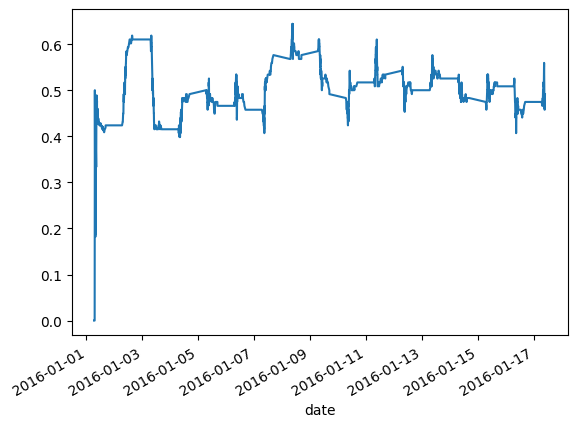

In [29]:
df["date"] = pd.to_datetime(df["date"])

df = df.set_index('date').sort_index()
df["label"].rolling("1D").mean().plot()

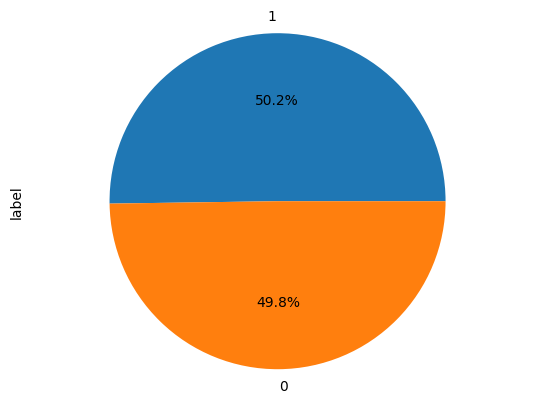

In [30]:
import matplotlib

import matplotlib.pyplot as plt

df['label'].value_counts().plot.pie(autopct='%1.1f%%',)
plt.axis('equal')
plt.show()